## As a homework now try it out this one: Corrective RAG(Type of the Agentic RAG)

in this architecutre you are correcting the infomation from any other data source if retriever is not able to generate a correct output(in this architecture the external data source is web search)

1. take multiple data sources and complex data sources
2. strict your prompting in every node based on your desired output
3. check question and generated docuemnt(k=keep more than 5 with strict prompting according to your usecase)

![alt text](download.png)

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

### Getting the model

In [1]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",
    temperature=0
)

response=llm.invoke("what is length of wall of china?")

response

AIMessage(content="<think>\nOkay, so I need to figure out the length of the Great Wall of China. I remember hearing that it's really long, but I'm not exactly sure how long. I think it's somewhere in the thousands of kilometers, but I'm not certain. Let me try to break this down.\n\nFirst, I know the Great Wall is a series of fortifications built across several Chinese dynasties. It wasn't built all at once, so maybe that's why the length can vary. I've heard different numbers before, like 13,000 miles or something like that, but I'm not sure if that's accurate.\n\nI should consider the different dynasties and how much each contributed to the wall. The Qin Dynasty, I think, was the first to build a long version of the wall, but it was probably not as extensive as later versions. Then the Han Dynasty might have extended it further. The most famous parts were probably built during the Ming Dynasty, which was much later.\n\nI also remember that the wall isn't a single continuous structure

In [3]:
import os
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

g:\AgenticAI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
g:\AgenticAI\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Harshit\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see 

In [10]:
print(len(embeddings.embed_query("Hi")))

768


### Data Ingestion

In [6]:
from langchain_community.document_loaders import WebBaseLoader


urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

docs=[WebBaseLoader(url).load() for url in urls]

docs_list=[item for sublist in docs for item in sublist]

### Chunking

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter 

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=25
    )

doc_splits = text_splitter.split_documents(docs_list)

texts = [doc.page_content for doc in doc_splits]
metadatas = [doc.metadata for doc in doc_splits]

### FAISS

In [11]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore

index=faiss.IndexFlatIP(768)

vectorstore=FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vectorstore.add_texts(texts, metadatas=metadatas)

['f989055c-79f5-48a8-ba36-cf2cb819b628',
 '45b2d2ae-8932-4d87-8f71-af9842e9098c',
 '08dd6657-0ad8-494f-8895-c9f9b028e8e7',
 'b8fbc3b5-5c2f-444d-891c-ec1b7f91f3c4',
 'de9b59b3-9903-4075-ab7f-a2be9502997f',
 'f69e6f7d-8cf1-4ae5-9bfc-f961854e47ac',
 'e27eb118-0c4f-4754-8c25-e9cf7df3bacf',
 '9a275d75-8a8d-4781-b0df-2fd2620174f2',
 '0d2717f1-52de-486d-a0ac-b0986224b8cf',
 '7546f7e1-b156-4960-8232-3d8d8aad3253',
 '66a966de-ec20-4e16-b214-e2fa8d6de8d0',
 'ab210ad4-57fb-4f70-a33f-fb63af973c5d',
 '46bf643f-5769-4d08-aa84-7b978a78c5cc',
 '2bdf376f-391f-48ab-921c-aae8469fcd98',
 '5507f8b6-5177-4249-8d76-8d56089b8aa5',
 'b8620c4f-7db1-49e2-82bf-f85ae89f0ac8',
 'ab15925c-6fca-484f-9607-65e047d66675',
 '1a698c71-8e52-4eb2-a525-ba337f846053',
 'fac6a335-f5af-4067-a861-32d6d7b4e243',
 '3b3373a4-d353-409c-ab90-c1de445ce572',
 '3d1e59ae-c10c-475c-b738-0632f7df86e2',
 '11a40f4a-cdd5-449d-a7d1-066297e68f0e',
 '0afae054-5de8-484b-aaed-3fcbd0100ad5',
 '1b02ff81-d5cd-4700-b433-21828b329ad6',
 '6e1e6254-623c-

### Agentic Workflow

In [12]:
retriever=vectorstore.as_retriever()

retriever.invoke("what is agent and prompt?")

[Document(id='f5c8b7cb-5f50-4a32-be4b-177d2d3838a9', metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log", 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en'}, page_content='Prompt is a sequence of prefix tokens that increase the probability of getting  desired output'),
 Document(id='5507f8b6-5177-4249-

In [39]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    "retriever_blog_post",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [40]:
# Search tool

from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

search.invoke("what is the latest update on iphone17 release?")

g:\AgenticAI\venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


"Jul 11, 2025 · Release Date & Lineup Apple is expected to announce the iPhone 17 series between September 9–13, 2025, with pre-orders likely to open by September 12 and a retail release … 4 days ago · The \u200cPlus device is being replaced with an all-new ultra-thin model, while the iPhone 17 Pro and \u200ciPhone 17 Pro\u200c Max are set to feature … Jul 14, 2025 · Here's the latest on rumored features on the iPhone 17 Pro, including potential changes by Apple and what you might pay for the phone due to the Trump tariffs. Jul 2, 2025 · Apple’s iPhone 17 is poised to be a significant release, combining subtle design enhancements with strategic updates to maintain its position in the competitive smartphone market. Jul 10, 2025 · There aren’t many iPhone 17 release date rumors yet, but we don’t really need any, as Apple tends to …"

In [41]:
tools=[retriever_tool]
llm_with_tool = llm.bind_tools(tools)

In [42]:
from langgraph.prebuilt import ToolNode

retriever_node = ToolNode(tools)

In [43]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Pydantic Class 
class grade(BaseModel):
    binary_score:str=Field(description="Relvance score 'yes', 'no'")

In [44]:
def LLM_Decision_Maker(state:AgentState):
    print("----CALL LLM_DECISION_MAKE----")
    message=state["messages"]
    last_message=message[-1]
    question=last_message.content
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}

In [45]:
def grade_documents(state: AgentState):
    print("----CALLING GRADE FOR CHECKING RELEVANCY----")

    llm_with_structure = llm.with_structured_output(grade)

    prompt = PromptTemplate(
        template = """
        You are a grader deciding if a document is relevant to a user’s question.
        Here is the document: {context}
        Here is the user’s question: {question}
        If the document talks about or contains information related to the user’s question, mark it as relevant. 
        Give a 'yes' or 'no' answer to show if the document is relevant to the question
        """,
        input_variables=["context", "question"]
    )

    chain = prompt | llm_with_structure

    message = state["messages"]
    last_message = message[-1]

    question = message[0].content

    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score=="yes":
        print("----DECISION: DOCS ARE RELEVANT----")
        return "generator"
    
    else:
        print("----DECISION: DOCS ARE NOT RELEVANT----")
        return "rewriter"

In [46]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [47]:
from langchain import hub

def generate(state: AgentState):
    message = state["messages"]
    question = message[0].content
    docs = message[-1].content

    prompt = hub.pull("rlm/rag-prompt")

    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})

    print("This is my response: {response}")

    return {"messages": [response]}



In [51]:
from langchain_core.messages import HumanMessage, AIMessage

def rewriter(state: AgentState):
    print("----Rewrite Entire Context Using Internet----")
    message = state["messages"]

    question = message[0].content

    new_ques = "Find the relevant context for " + question

    search_res = search.invoke(new_ques)

    response = [HumanMessage(content= search_res)]

    return {"messages": response} 

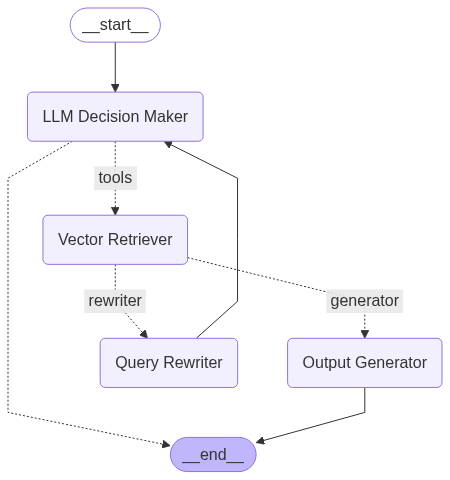

In [52]:
# Agentic Orchestration

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import tools_condition

workflow=StateGraph(AgentState)

workflow.add_node("LLM Decision Maker",LLM_Decision_Maker)
workflow.add_node("Vector Retriever",retriever_node)
workflow.add_node("Output Generator",generate)
workflow.add_node("Query Rewriter",rewriter)

workflow.add_edge(START,"LLM Decision Maker")
workflow.add_conditional_edges("LLM Decision Maker",
                               tools_condition,
                               {"tools":"Vector Retriever",
                                END:END
                                })
workflow.add_conditional_edges("Vector Retriever",
                               grade_documents,
                               {"generator":"Output Generator",
                                "rewriter":"Query Rewriter",
                                })
workflow.add_edge("Output Generator",END)
workflow.add_edge("Query Rewriter","LLM Decision Maker")

app=workflow.compile()
app

In [53]:
app.invoke({"messages":["what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE RELEVANT----
This is my response: {response}


{'messages': [HumanMessage(content='what is LLM Powered Autonomous Agents explain the planning and reflection and prompt engineering explain me in terms of agents and langchain?', additional_kwargs={}, response_metadata={}, id='a3bf6390-178c-4238-bb84-8a244904bb36'),
  AIMessage(content="To address your query about LLM-powered autonomous agents, planning, reflection, prompt engineering, and their relationship with LangChain, I will use the retriever tool to fetch relevant information from Lilian Weng's blog posts.\n\n", additional_kwargs={'reasoning_content': "Okay, so the user is asking about LLM-powered autonomous agents, specifically focusing on planning, reflection, prompt engineering, and how these relate to LangChain. Hmm, I need to break this down.\n\nFirst, I should recall what an LLM-powered autonomous agent is. It's like a system that uses large language models to perform tasks on its own, right? So, planning would be how the agent decides what steps to take. Maybe it uses th

In [59]:
app.invoke({"messages":["what is talked about Corrective RAG in articles?"]})

----CALL LLM_DECISION_MAKE----
----CALLING GRADE FOR CHECKING RELEVANCY----
----DECISION: DOCS ARE NOT RELEVANT----
----Rewrite Entire Context Using Internet----


g:\AgenticAI\venv\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


----CALL LLM_DECISION_MAKE----


{'messages': [HumanMessage(content='what is talked about Corrective RAG in articles?', additional_kwargs={}, response_metadata={}, id='4e707bb2-c7cc-4c9b-9fe8-f859b5378fb9'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about Corrective RAG in articles. I remember that RAG stands for Retrieval-Augmented Generation, which is a method used in language models to improve their responses by accessing external information. But I\'m not exactly sure what "Corrective RAG" specifically refers to. \n\nI should check if there\'s any information on this in the available tools. The only tool provided is the "retriever_blog_post" function, which is specialized for Lilian Weng\'s blog posts on LLMs, prompt engineering, and adversarial attacks. Since the user\'s query is about RAG, which is related to LLMs, I can use this tool to find relevant information.\n\nI\'ll call the retriever_blog_post function with the query "Corrective RAG". This should search thr